# Final Analysis

Now that we have cleaned, filtered and preprocessed our data, we can proceed to analyse it to see whether any conclusions can be drawn from the found matches.

This will be done in two parts:

First, we check whether any of the addresses, if present, of the shell companies is near the headquarter location of the charity it matches against.

Secondly, we will create graphs of all the found shell companies to analyse their distribution in the leaked papers.

__Note that in order to connect nodes to each other, both these points rest on substantial preprocessing done in the "Connections" notebook, which can be consulted for a better understanding of the structures being dealt with.__

In [1]:
#Imports
import pandas as pd

#Spark
import findspark
#findspark.init(r"C:\Users\Lucas\Desktop\ADA\spark-2.3.2-bin-hadoop2.7")
findspark.init('/opt/spark/spark-2.3.2-bin-hadoop2.7/')

from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.functions import min
from pyspark.sql.functions import udf
from pyspark.sql.functions import split
from pyspark.sql.functions import explode

from pyspark.sql.types import StringType
from pyspark.sql.types import TimestampType

from pyspark.sql import SparkSession
from pyspark import SparkContext

spark = SparkSession.builder.getOrCreate()


#imports
import networkx as nx

from operator import itemgetter
import collections
from community import community_louvain
from networkx.algorithms.community.centrality import girvan_newman
import itertools

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Addresses

Our goal is to find addresses connected to shell companies and see if the match the headquarters of the charity. This could be seen as a red flag that the shell company indeed represents the charity it was matched with.

In [2]:
#We can reuse the filtering functions from earlier, this time looking specifically 
#for edges of type "address" connected to nodes of type entity

def filter_edges(edges, nodes):
    '''Given a set of nodes, returns the edges connected to those nodes'''
    
    entity_ids = nodes.map(lambda r: r[0]).collect()
    
    return edges.filter(lambda r: r[0] in entity_ids or r[2] in entity_ids)

def filter_nodes(nodes, edges):
    '''Given a set of edges, return the nodes connected to those edges'''
    
    start_ids = edges.map(lambda r: r[0]).collect()
   
    end_ids = edges.map(lambda r: r[2]).collect()
    
    return nodes.rdd.filter(lambda r: r[0] in start_ids or r[0] in end_ids)

In [3]:
def get_address_matches(leak):
    '''return the match node id of first level connection with registered address '''
    
    #return the path of edges csv file
    edges = spark.read.csv('../data/'+ leak + '/*.edges.csv', header=True)
    
    #return the path of address nodes csv file
    address_nodes = spark.read.csv('../data/' + leak + '/*address.csv', header=True)
    
    #filter the edges that contain a registered address
    address_edges = edges.rdd.filter(lambda r: r[1] == 'registered_address')
    
    #get the matches 
    matches= spark.read.csv('../generated/map/connections/entity/entity_' + leak + '_matches.csv', 
                            header=True).drop('_c0')
    
    #filter the edges connected to matches
    entity_address_edges = filter_edges(address_edges, matches.rdd)
    
    #filter thes nodes linked to these edges
    leak_address = filter_nodes(address_nodes,entity_address_edges)
    

    ''' Conversion of the spark dataframe in pandas ones : '''
    
    #for the matches :
    matches_pd = pd.DataFrame(matches.collect(), 
                              columns=["node_id","ShellName","CharityName","CharityHeadquarters"])
    
    matches_pd = matches_pd[matches_pd['CharityHeadquarters'].isnull() == False]
    
    #for the nodes connected to the matches :
    address_pd = pd.DataFrame(leak_address.collect(),
                            columns = ["node_id","name","address","country_codes","countries",
                                       "sourceID","valid_until","note"])
    
    #for the edges connected to the matches :
    entity_address_edges_pd = pd.DataFrame(entity_address_edges.collect(),
                            columns = ["node_id","TYPE","END_ID","link","start_date",
                                       "end_date","sourceID","valid_until"])
    
    '''Apply 'int' type to the columns used for the merge : '''
    
    
    #rename the column adequatly for merging
    address_pd.rename(columns = {'node_id':'END_ID'}, inplace=True)
    
    #drop unusefull columns in order to avoid conflict when merging
    address_pd.drop(['note','valid_until','sourceID'],axis = 1, inplace = True)
    
    #first we merge in order to obtain correspondance between the matches and 
    #the corresponding edges with registered adress
    maches_edges = matches_pd.merge(entity_address_edges_pd, on = 'node_id')
    
    #then to node linked to these edges
    matches_nodes = maches_edges.merge(address_pd, on = 'END_ID')

    return matches_nodes

In [4]:

leaks = ['panama', 'paradise', 'offshore', 'bahamas']
address_dfs = {}

print('number of address pairs found:')
for leak in leaks:
    address_df = get_address_matches(leak)
    print(leak +': ' + str(len(address_df)))
    address_dfs[leak] = address_df[['ShellName', 'CharityName', 
                                    'CharityHeadquarters', 'address', 'countries']]


number of address pairs found:
panama: 1
paradise: 55
offshore: 0
bahamas: 0


In [5]:
address_dfs['panama']

ShellName              CharityName  \
0  HERITAGE VALUE FOUNDATION  The Heritage Foundation   

                      CharityHeadquarters  \
0  214 Massachusetts Avenue NEWashington,   

                                             address countries  
0  Mossfon Building; Second Floor; East 54 th Str...    Panama

In [6]:
address_dfs['paradise']

ShellName  \
0                              The Duke Endowment   
1                             THE BUSH FOUNDATION   
2                           Amnesty International   
3          Memorial Sloan-Kettering Cancer Center   
4                     Goodwill Industries Captive   
5                                     Mayo Clinic   
6          Memorial Sloan-Kettering Cancer Center   
7                          The Nature Conservancy   
8   The Rotary Foundation of Rotary International   
9                      World Vision International   
10                                     Young Life   
11                        American Cancer Society   
12                                           SPCA   
13                 The Metropolitan Museum of Art   
14                            WORLD WILDLIFE FUND   
15                             Vietnam Value Fund   
16                             Vietnam Value Fund   
17                        United Green Foundation   
18                      COMMUNITY RESOURCE CENTER   
19                STICHTING SURGYSCOPE FOUNDATION   
20                        STICHTING JE FOUNDATION   
21                  STICHTING POSITIVE FOUNDATION   
22       ZION CRECHE CHILD DEVELOPMENT FOUNDATION   
23       ZION CRECHE CHILD DEVELOPMENT FOUNDATION   
24                                            LA    
25           THE ARUBA HERITAGE MUSEUM FOUNDATION   
26                   STICHTING MICKY'S FOUNDATION   
27        FOUNDATION FOR ISLAMIC DEVELOPMENT INC.   
28        FOUNDATION FOR ISLAMIC DEVELOPMENT INC.   
29               INTERNATIONAL VOLUNTEER SERVICES   
30               INTERNATIONAL VOLUNTEER SERVICES   
31                   Bermuda Diabetes Association   
32                   International Solar Services   
33                  ALLIED SERVICES INTERNATIONAL   
34                              NEW YORK NEW YORK   
35                     ABC INTERNATIONAL SERVICES   
36                     ABC INTERNATIONAL SERVICES   
37                   KLING INTERNATIONAL SERVICES   
38                                            360   
39                  MAHALI SERVICES INTERNATIONAL   
40                  PROFAD INTERNATIONAL SERVICES   
41                INTERNATIONAL FORENSIC SERVICES   
42                INTERNATIONAL FORENSIC SERVICES   
43                                    NEW BIG NEW   
44                 SERVICES INTERNATIONAL LIMITED   
45                              VISION WORLD INC.   
46                         THE NATURE CONSERVANCY   
47                         THE NATURE CONSERVANCY   
48                      INTERNATIONAL RESCUE LTD.   
49                      INTERNATIONAL RESCUE LTD.   
50                 INTERNATIONAL SERVICES LIMITED   
51                               Vision World Ltd   
52                     SERVICES INTERNATIONAL LTD   
53                                          CRU 2   
54                                            MAP   

                                  CharityName  \
0                          The Duke Endowment   
1                             Bush Foundation   
2                       Amnesty International   
3      Memorial Sloan Kettering Cancer Center   
4           Goodwill Industries International   
5                                 Mayo Clinic   
6      Memorial Sloan Kettering Cancer Center   
7                          Nature Conservancy   
8   Rotary Foundation of Rotary International   
9                                World Vision   
10                                 Young Life   
11                    American Cancer Society   
12                              American SPCA   
13                 Metropolitan Museum of Art   
14                        World Wildlife Fund   
15                    Vietnam Children's Fund   
16                    Vietnam Children's Fund   
17                  United Nations Foundation   
18                    Jewish Community Center   
19                 Stichting INGKA Foundation   
20                 Stichting INGKA Foundat

## Graphs

Using the previously collected data detailing how matches connect to the rest of the leaked information, we can create graphs and see the degree of interconnectivity between the matches.

We only use degree 1, as larger degrees resulted in unmanagably large graphs. But distance 1 is quite good enough for our purposes.

In [7]:
#Global variables 

DEGREE = 1

DEGREE_FILE = '../generated/map/degree_' + str(DEGREE) +'/'

def get_graph_elem_file(elem_type, leak):
    return DEGREE_FILE + leak + '_' + elem_type + '.csv'

### Create the graphs

Note that as some of the graphs have still very many nodes, we can choose to filter these down to only those connected to more than one node (unless a node is a match -- we still want to know who is not connected to anyone).

Note the special attention drawn to the "bahamas" leak, which has a slightly different schema.

In [8]:
def remove_loners(full_df):
    
    '''Removes nodes with fewer than 2 connections who are not matches'''
    
    node_counts = full_df['START_ID'].append(full_df['END_ID']).value_counts()

    ids_to_remove = []

    for index, row in full_df.iterrows():
        start_id = row['START_ID']
        end_id = row['END_ID']

        if (row['match_x'] == (False and node_counts[start_id] < 2) 
            or (row['match_y'] == False and node_counts[end_id] < 2)):
            ids_to_remove.append(index)
    
    return full_df.drop(full_df.index[ids_to_remove]).reset_index(drop=True)

def graph_leak_matches(leak, dense=False):
    
    '''Creates graphs of matches found in a given leak'''
    
    bahamas = (leak == 'bahamas')

    node_id = '0'
    name_index = '1'

    if bahamas:
        node_id = '4' 
        name_index = '7'

    plt.rcParams["figure.figsize"] = (23,23)

    
    #Load the data
    nodes = pd.read_csv(get_graph_elem_file('nodes', leak), index_col=0)\
                                                            .reset_index(drop=True)[[node_id, name_index, 'Match']]

    nodes.rename(columns={node_id:'node_id', name_index:'name', 'Match':'match'}, inplace=True)
    edges = pd.read_csv(get_graph_elem_file('edges', leak), index_col=0).reset_index(drop=True)[['START_ID', 'END_ID']]

    #Format the data as a set of edges with information about the nodes
    full_df = pd.merge(nodes, edges, left_on='node_id', right_on='START_ID')
    full_df = pd.merge(full_df, nodes, left_on='END_ID', right_on='node_id').drop(['node_id_x', 'node_id_y'], axis=1)
    
    #filter too large graphs if told so
    if dense:
        print('Size before removing loners: ' + str(len(full_df)))
        full_df = remove_loners(full_df)
        print('Size after removing loners: ' + str(len(full_df)))
    
    #create the graph
    graph = nx.from_pandas_edgelist(full_df, 'name_x', 'name_y', edge_attr=None, create_using= nx.Graph())
    
    #prepare for coloring the nodes according to if it is a match to a charity or not
    match_class_1 = full_df[['name_x', 'match_x']].rename(columns={'name_x':'name', 'match_x':'match'})
    match_class_2 = full_df[['name_y', 'match_y']].rename(columns={'name_y':'name', 'match_y':'match'})
    
    match_class = match_class_1.append(match_class_2).set_index('name')
    match_class = match_class[~match_class.index.duplicated(keep='first')]
    
    match_class = match_class.reindex(graph.nodes())
    match_class['match'] = pd.Categorical(match_class['match'])
    
    print('Matches for ' + leak + ' papers: ')
    print(nx.info(graph))
    
    #draw the graph
    nx.draw(graph, nx.spring_layout(graph, scale=60, k=0.25), with_labels=True, alpha=0.7, node_size=1000,
        node_color=match_class['match'].cat.codes, cmap=plt.cm.autumn)
    

    

### Display graphs

We display two graphs for each set of leaks, one with all the nodes, and a smaller, denser one with only nodes belonging to clusters of a certain size.

Matches for panama papers: 
Name: 
Type: Graph
Number of nodes: 100
Number of edges: 67
Average degree:   1.3400


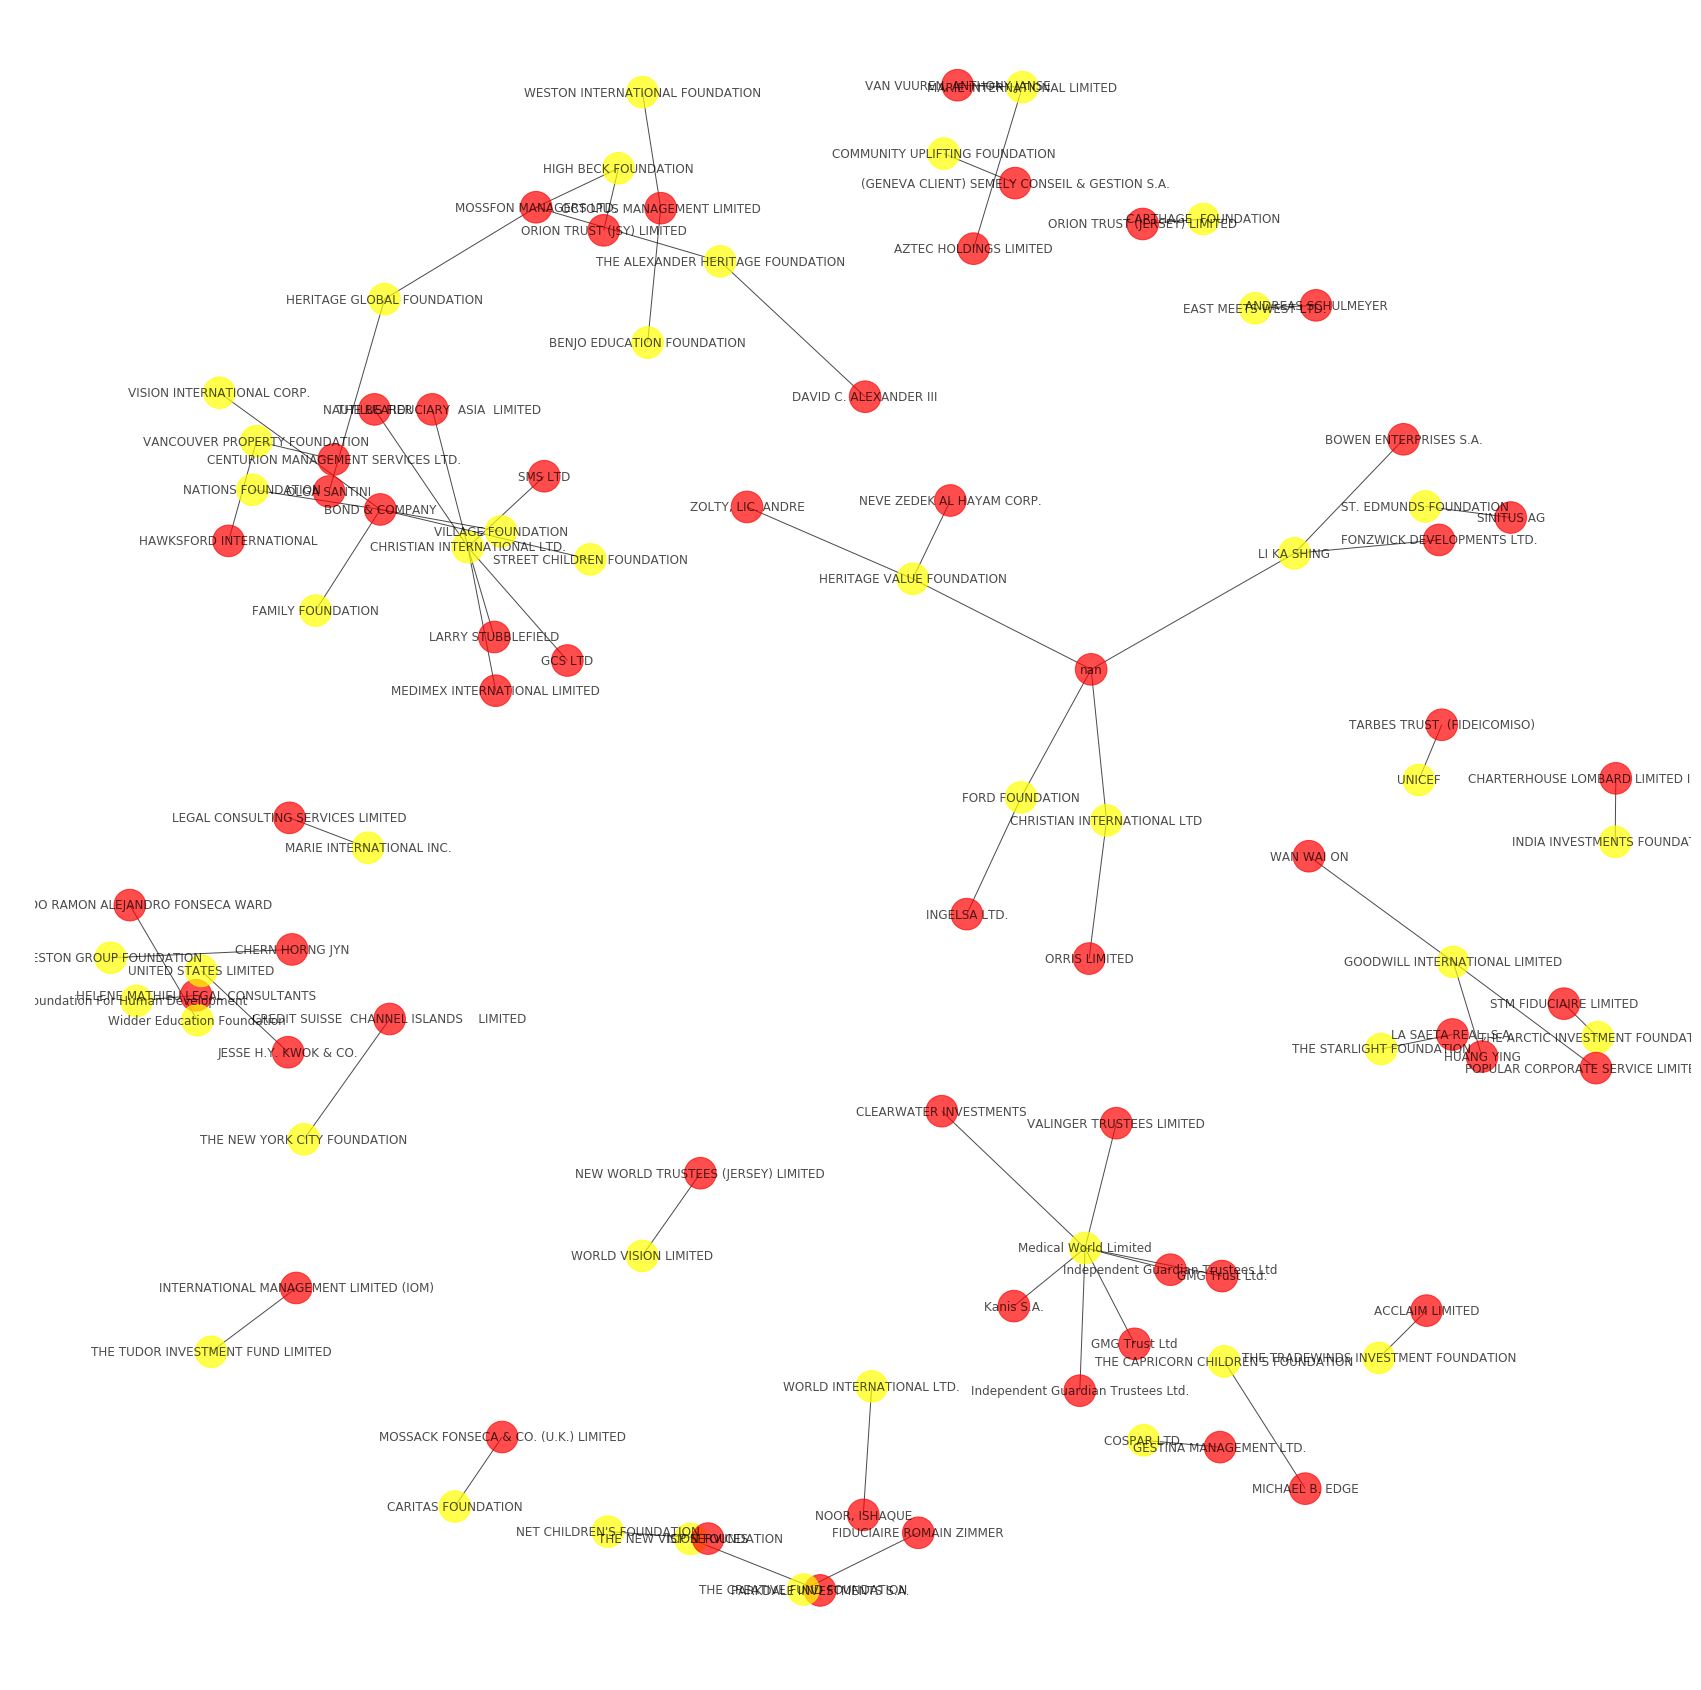

In [9]:
graph_leak_matches('panama')

Size before removing loners: 73
Size after removing loners: 2
Matches for panama papers: 
Name: 
Type: Graph
Number of nodes: 2
Number of edges: 1
Average degree:   1.0000


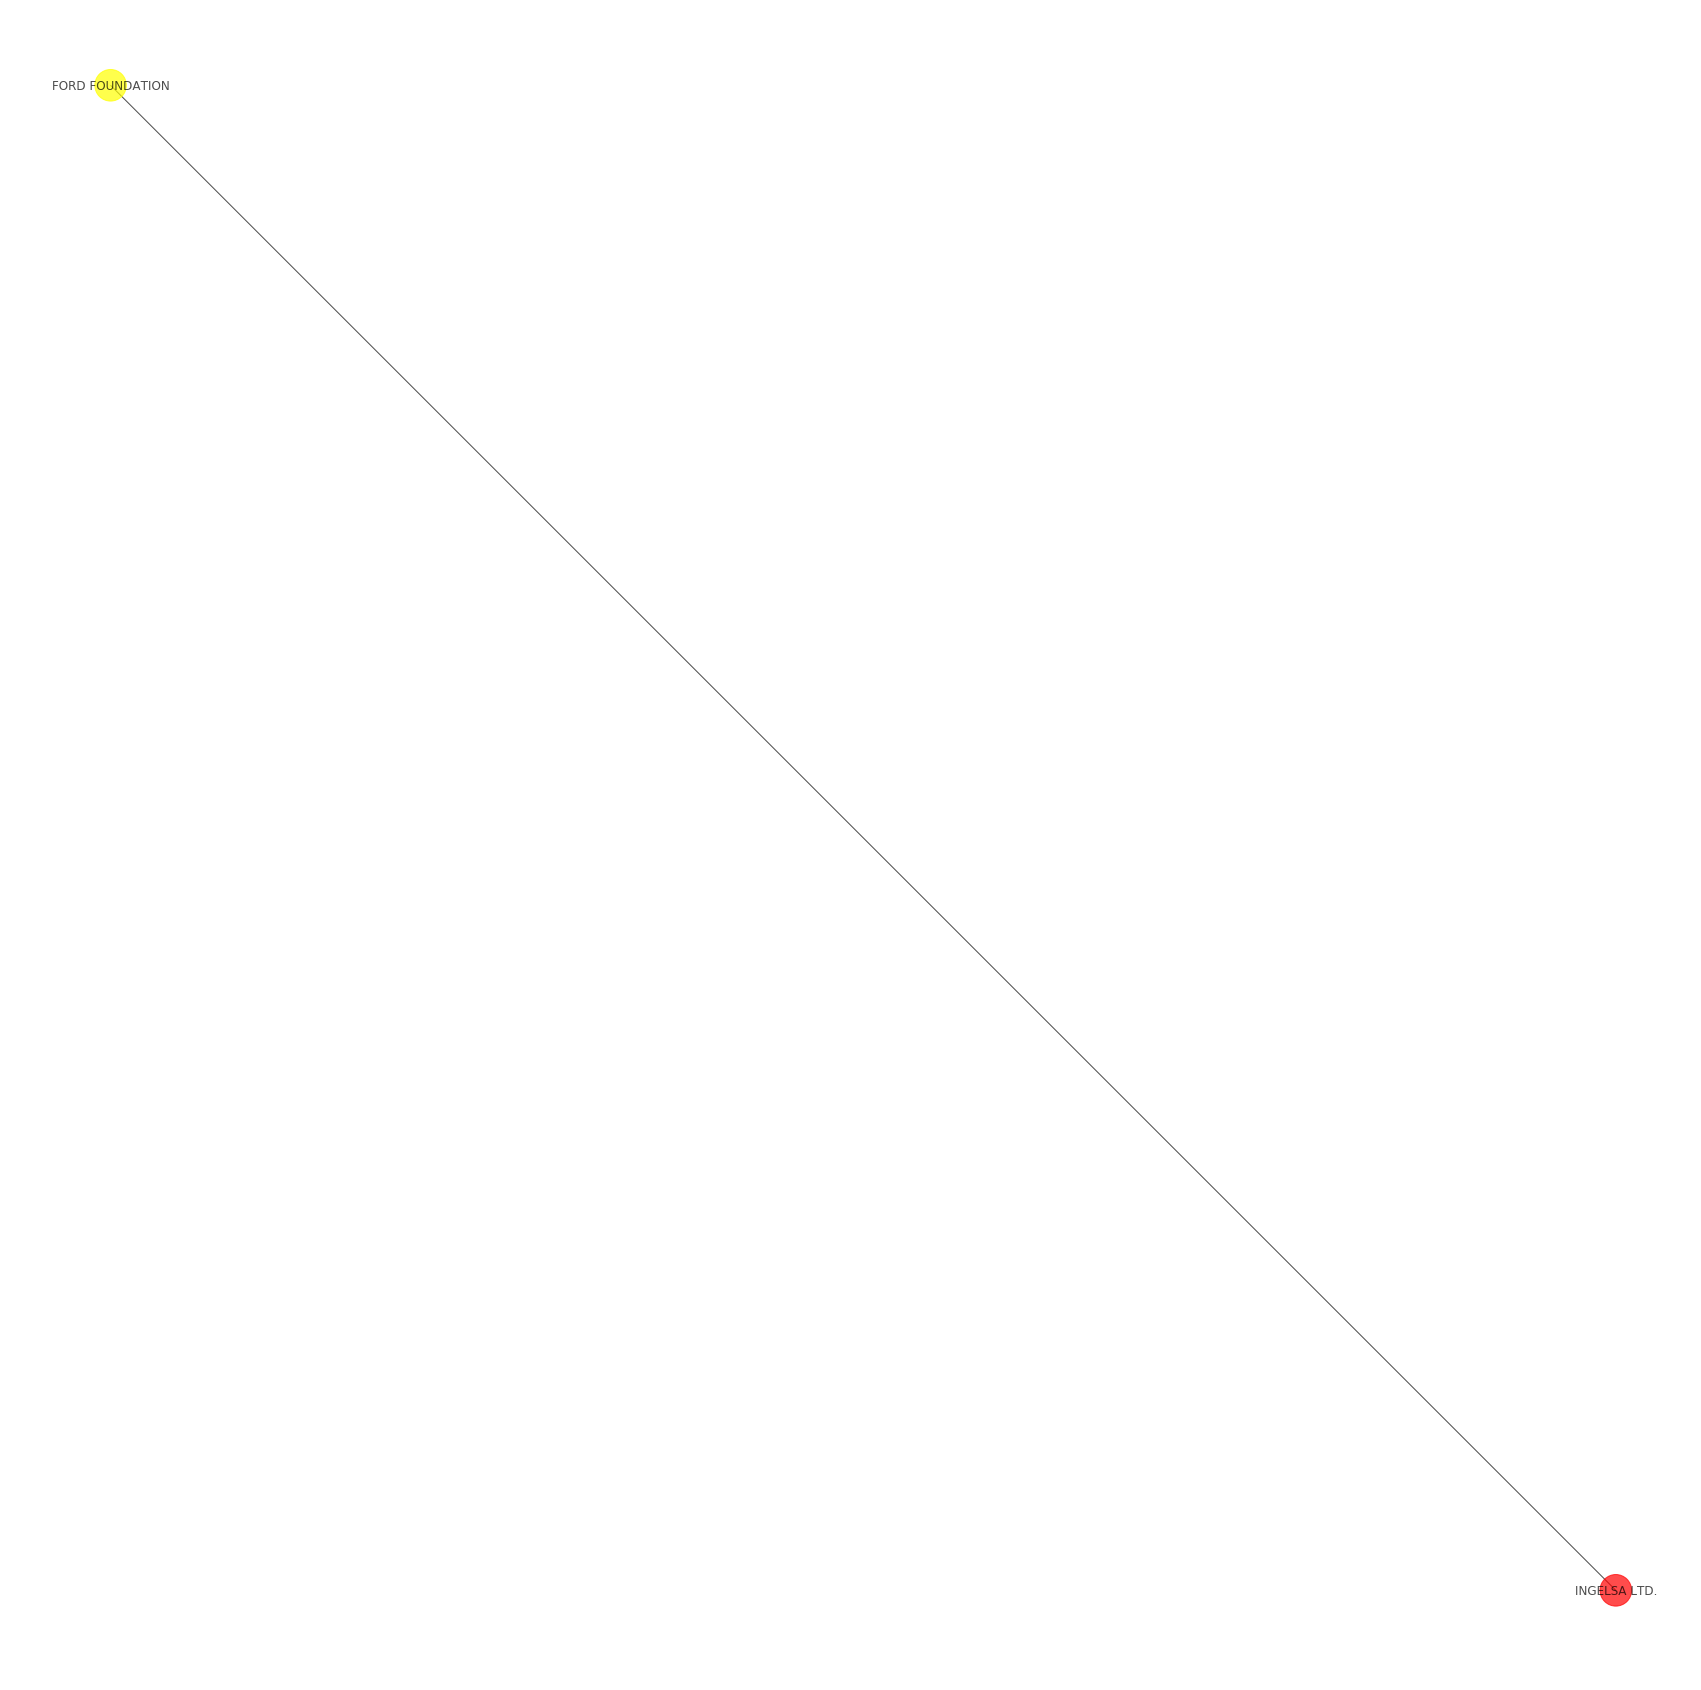

In [10]:
graph_leak_matches('panama', True)

Matches for paradise papers: 
Name: 
Type: Graph
Number of nodes: 456
Number of edges: 370
Average degree:   1.6228


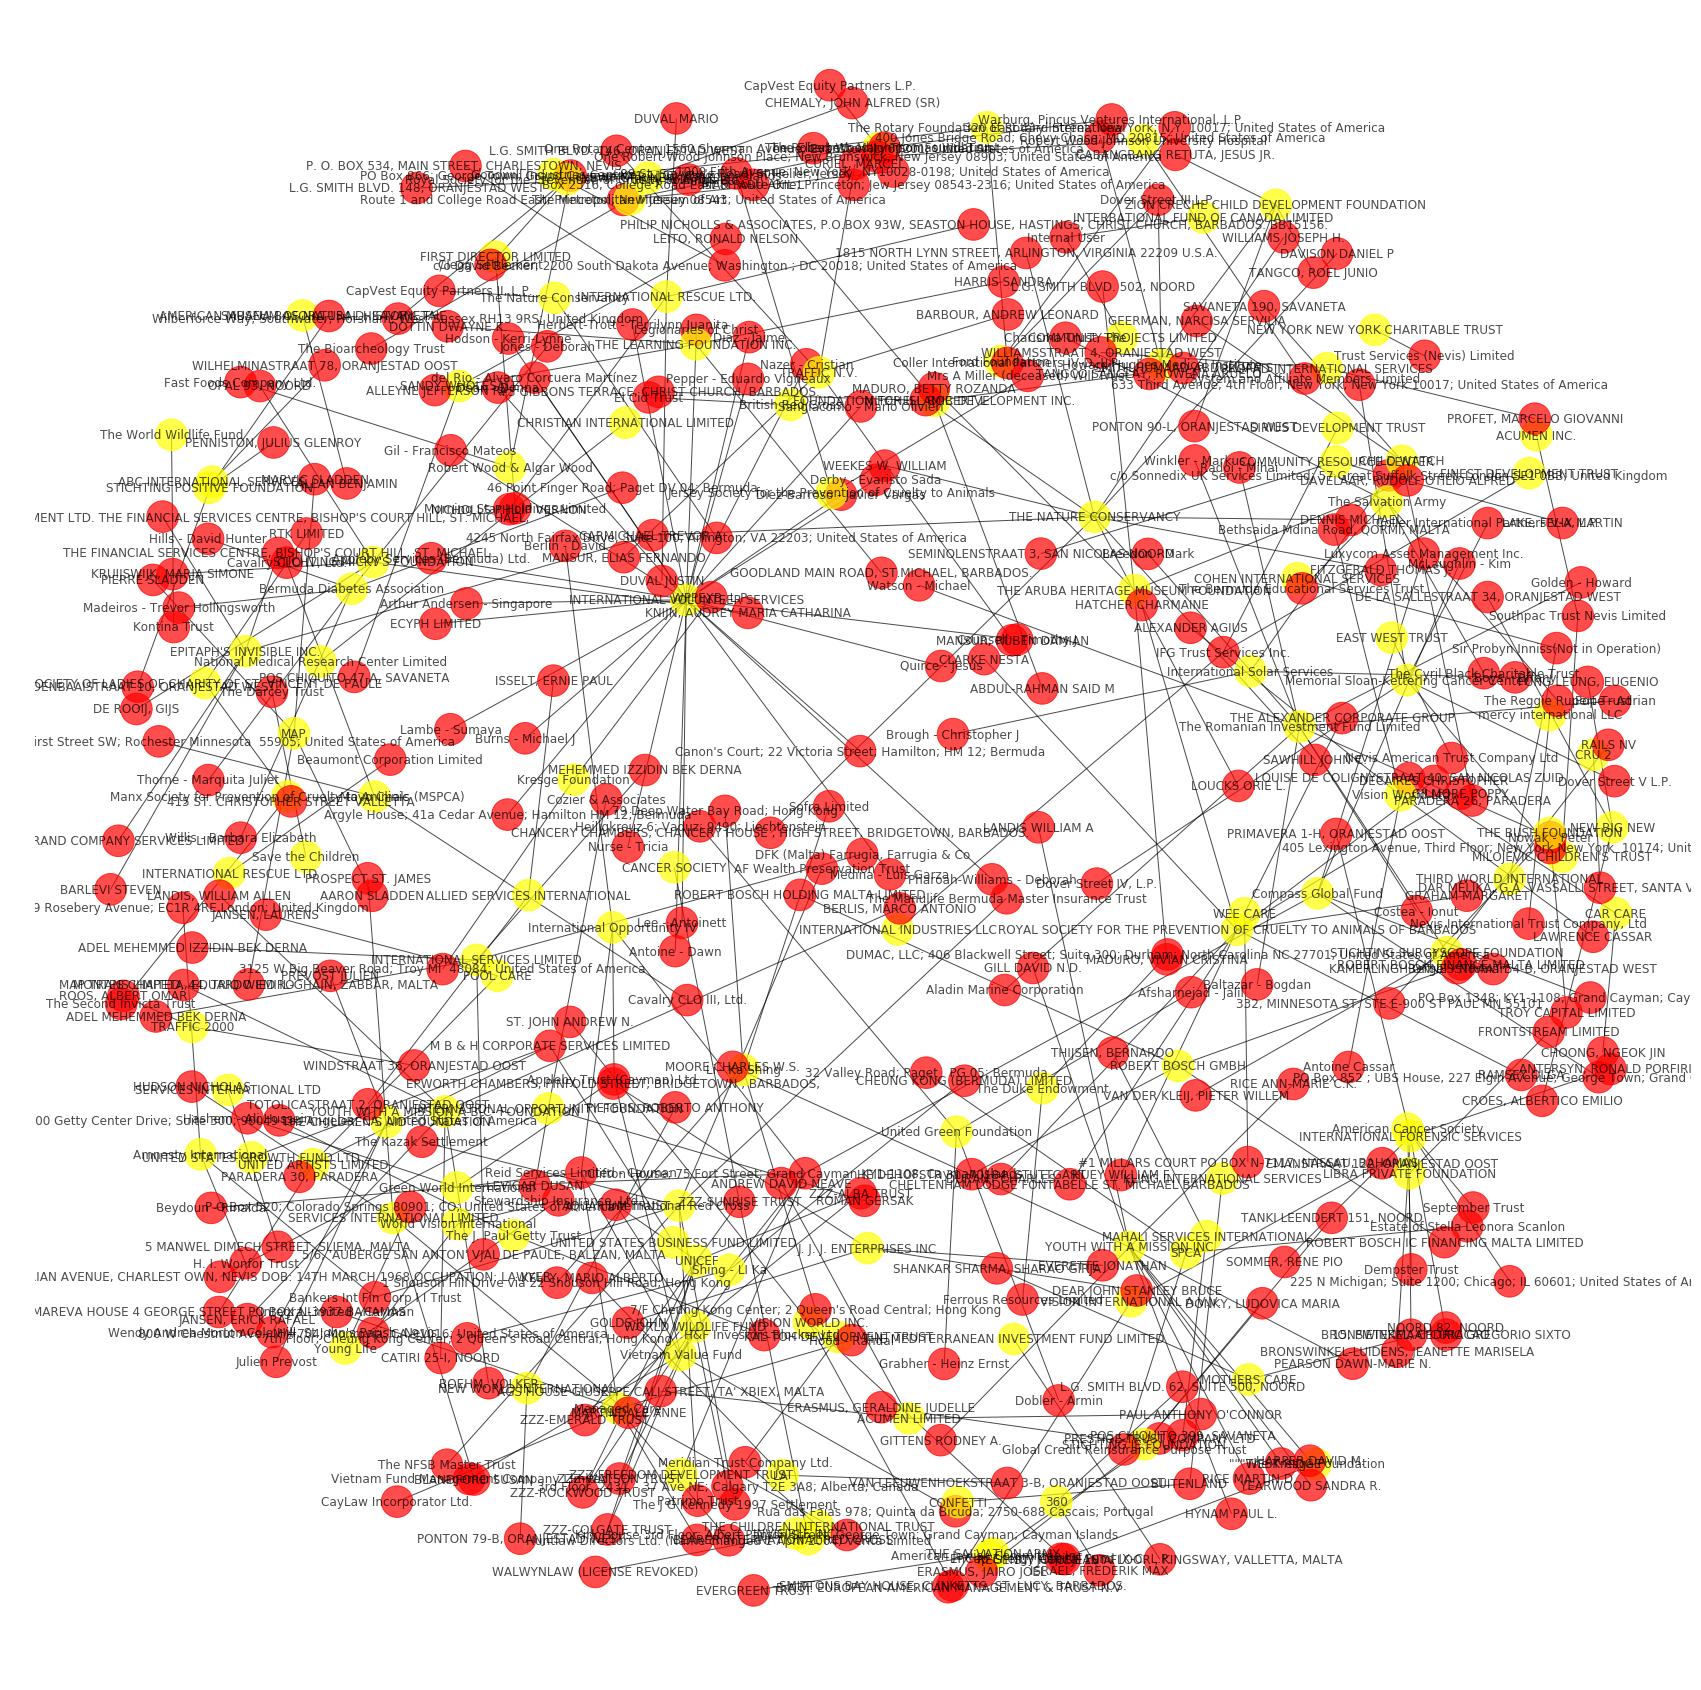

In [11]:
graph_leak_matches('paradise')

Size before removing loners: 414
Size after removing loners: 38
Matches for paradise papers: 
Name: 
Type: Graph
Number of nodes: 38
Number of edges: 35
Average degree:   1.8421


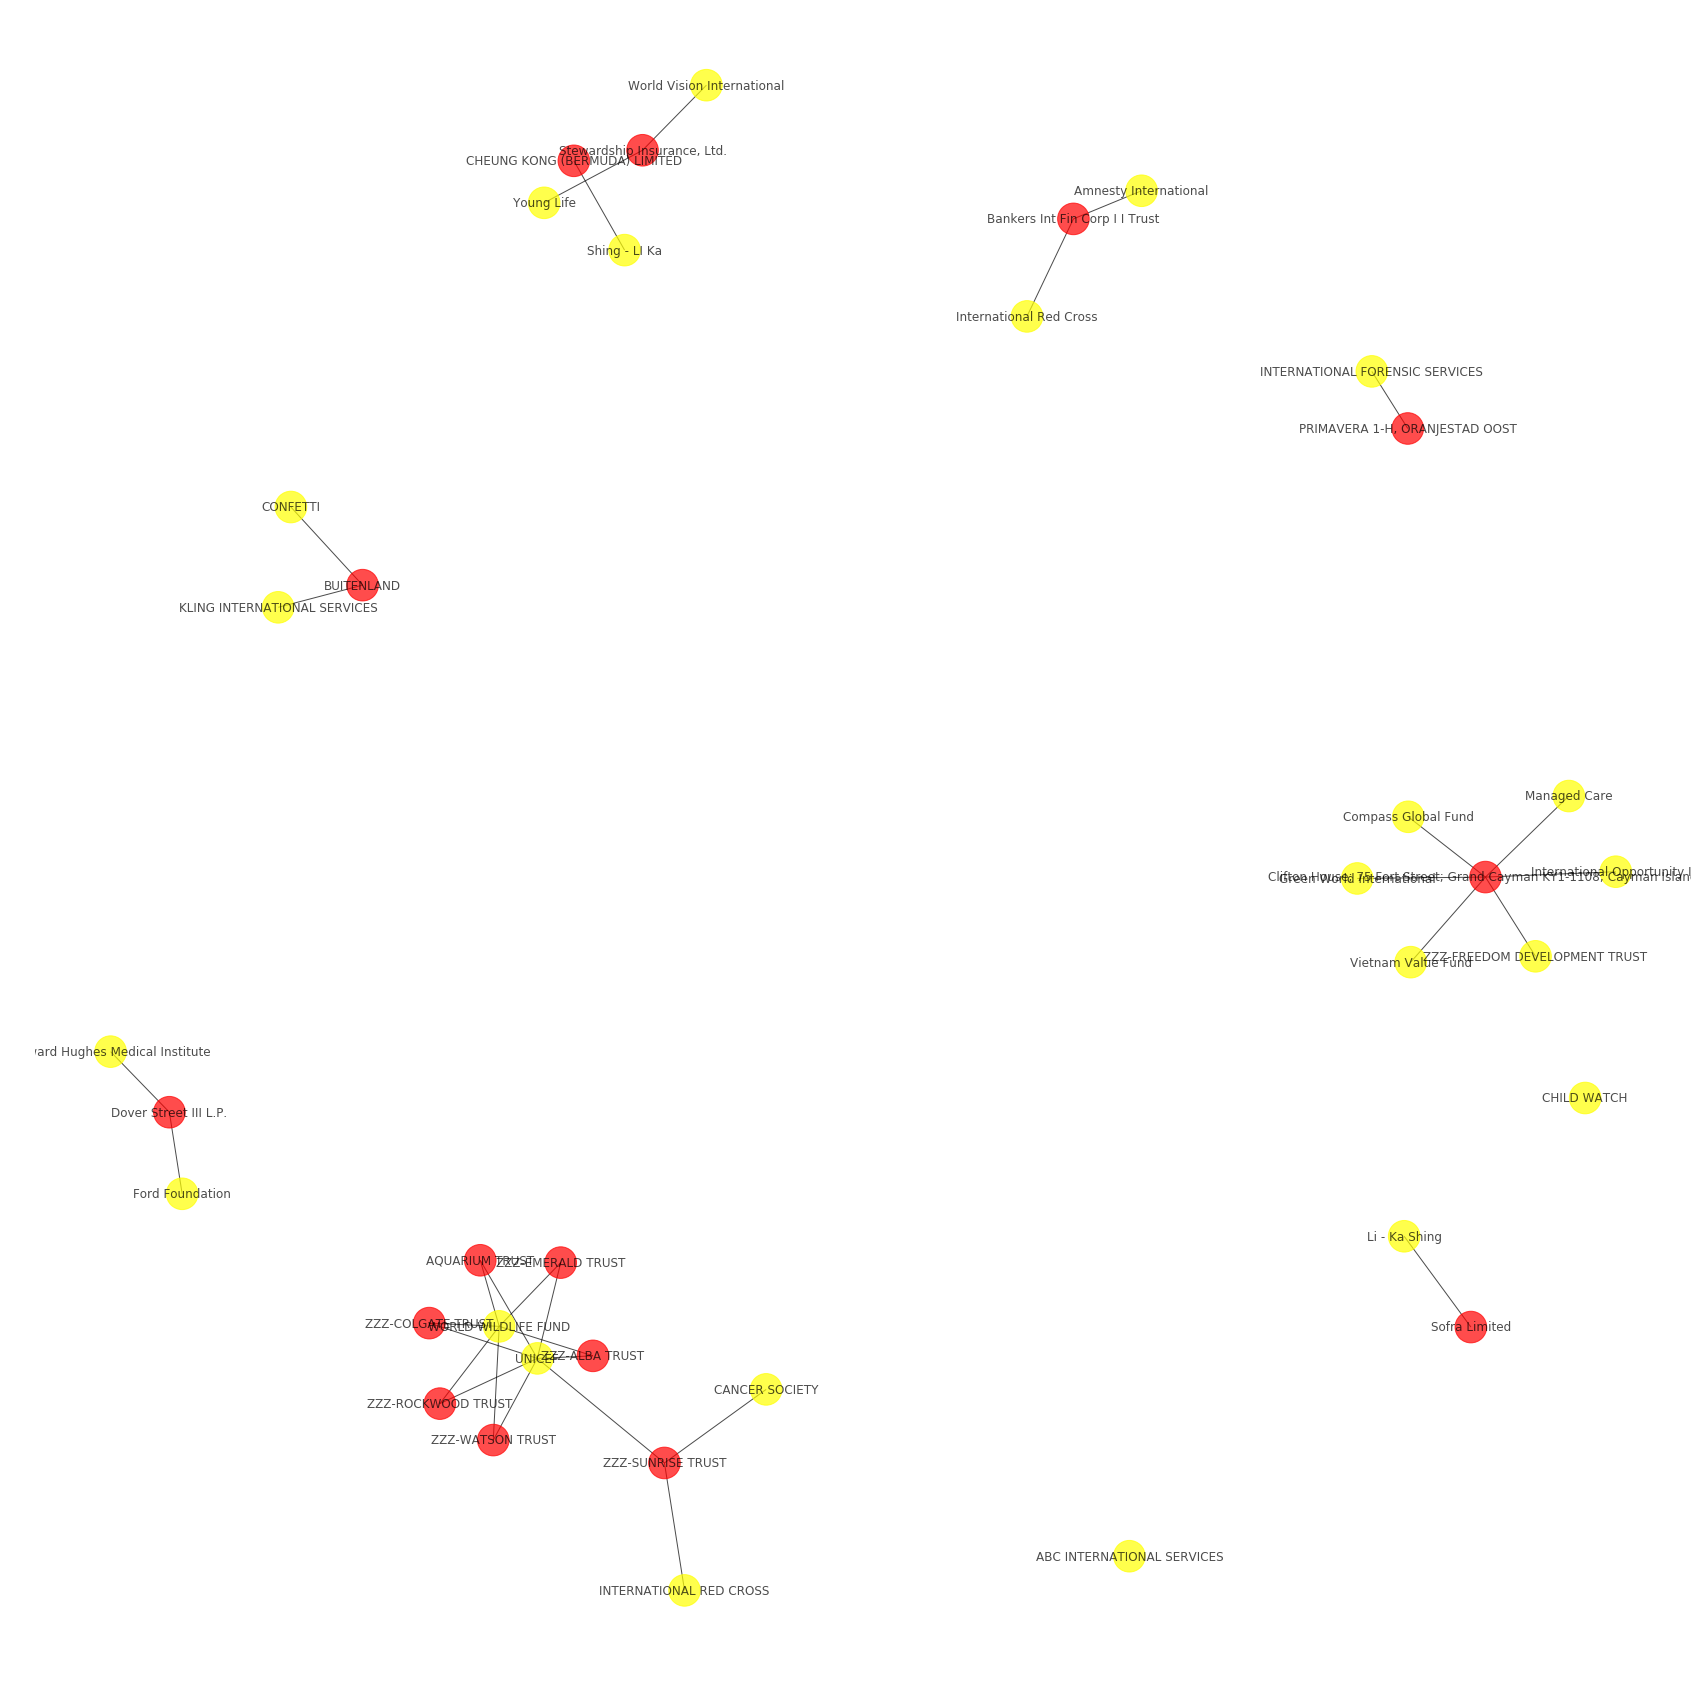

In [12]:
graph_leak_matches('paradise', True)

Matches for offshore papers: 
Name: 
Type: Graph
Number of nodes: 63
Number of edges: 56
Average degree:   1.7778


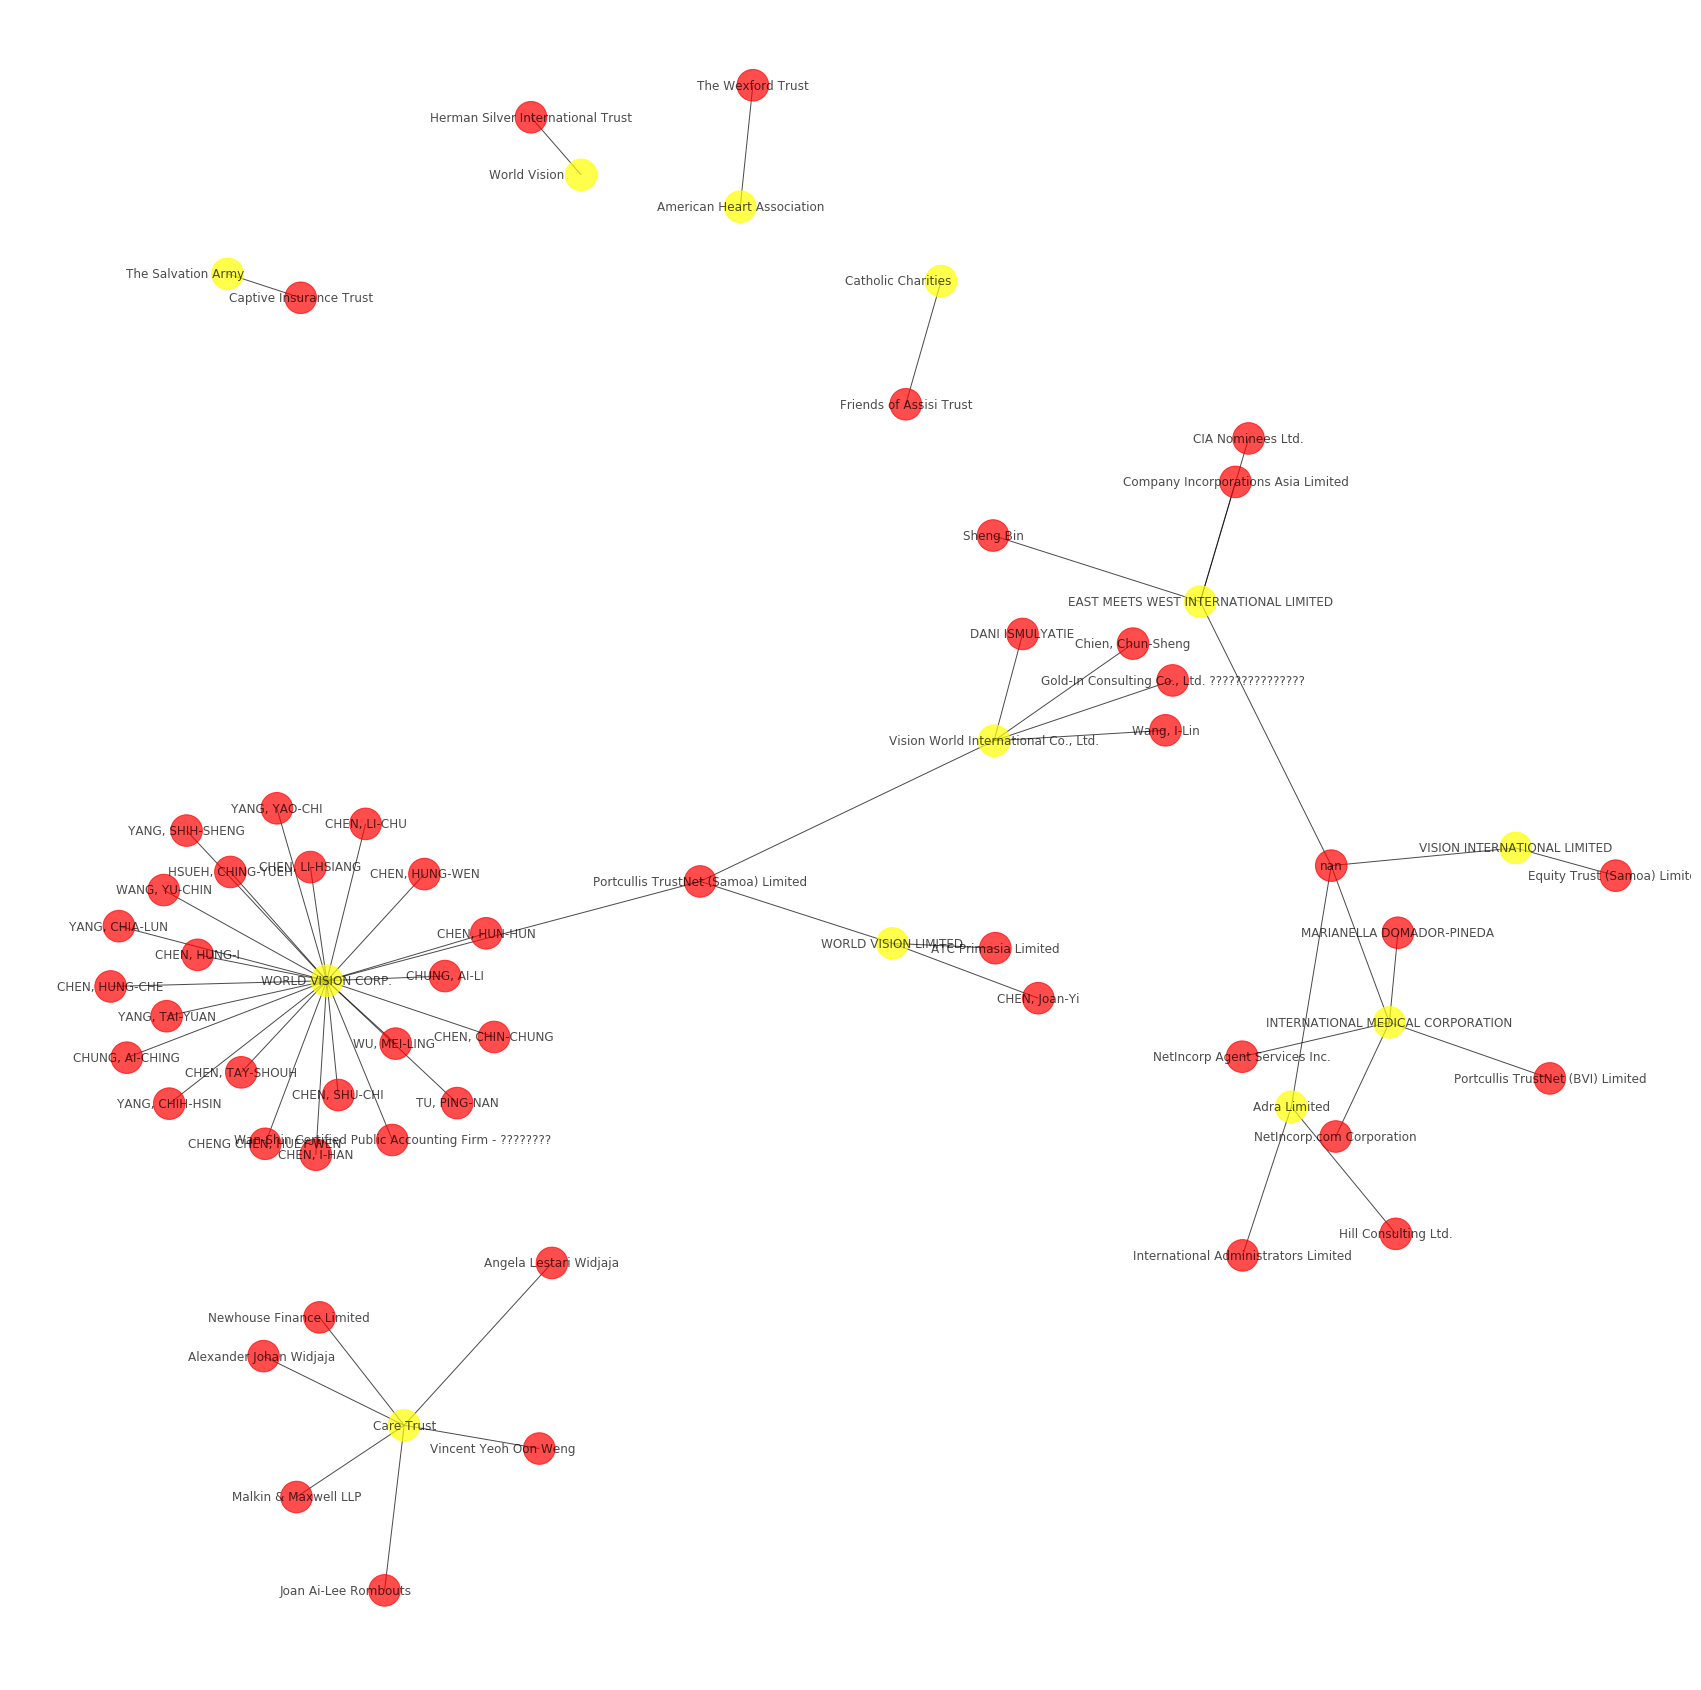

In [13]:
graph_leak_matches('offshore')

Size before removing loners: 68
Size after removing loners: 0
Matches for offshore papers: 
Name: 
Type: Graph
Number of nodes: 0
Number of edges: 0



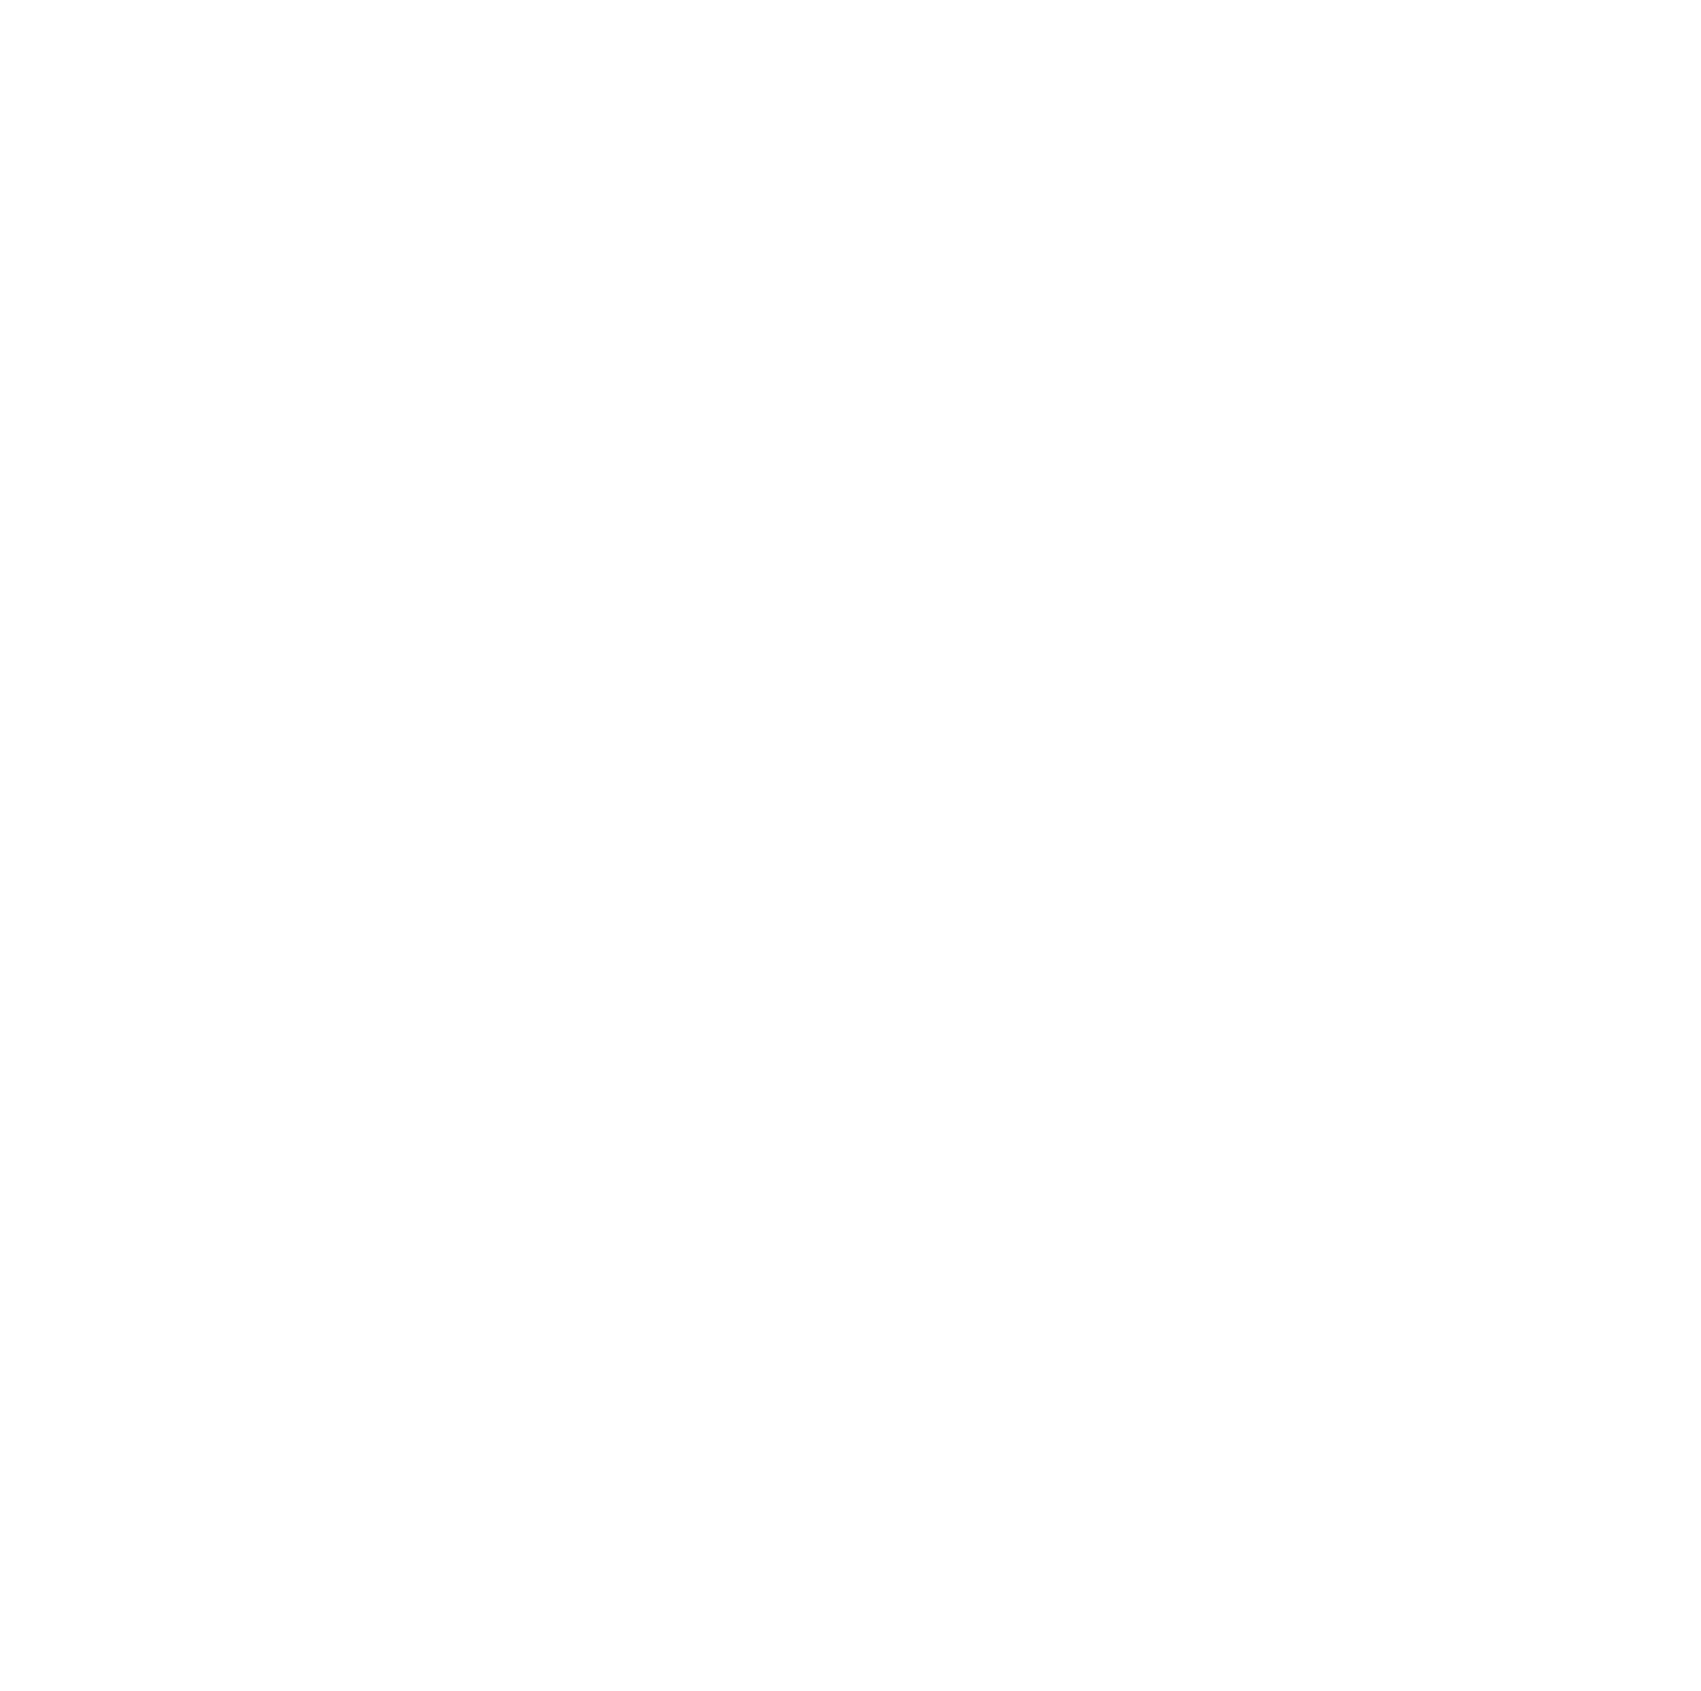

In [14]:
graph_leak_matches('offshore', True)

Matches for bahamas papers: 
Name: 
Type: Graph
Number of nodes: 44
Number of edges: 26
Average degree:   1.1818


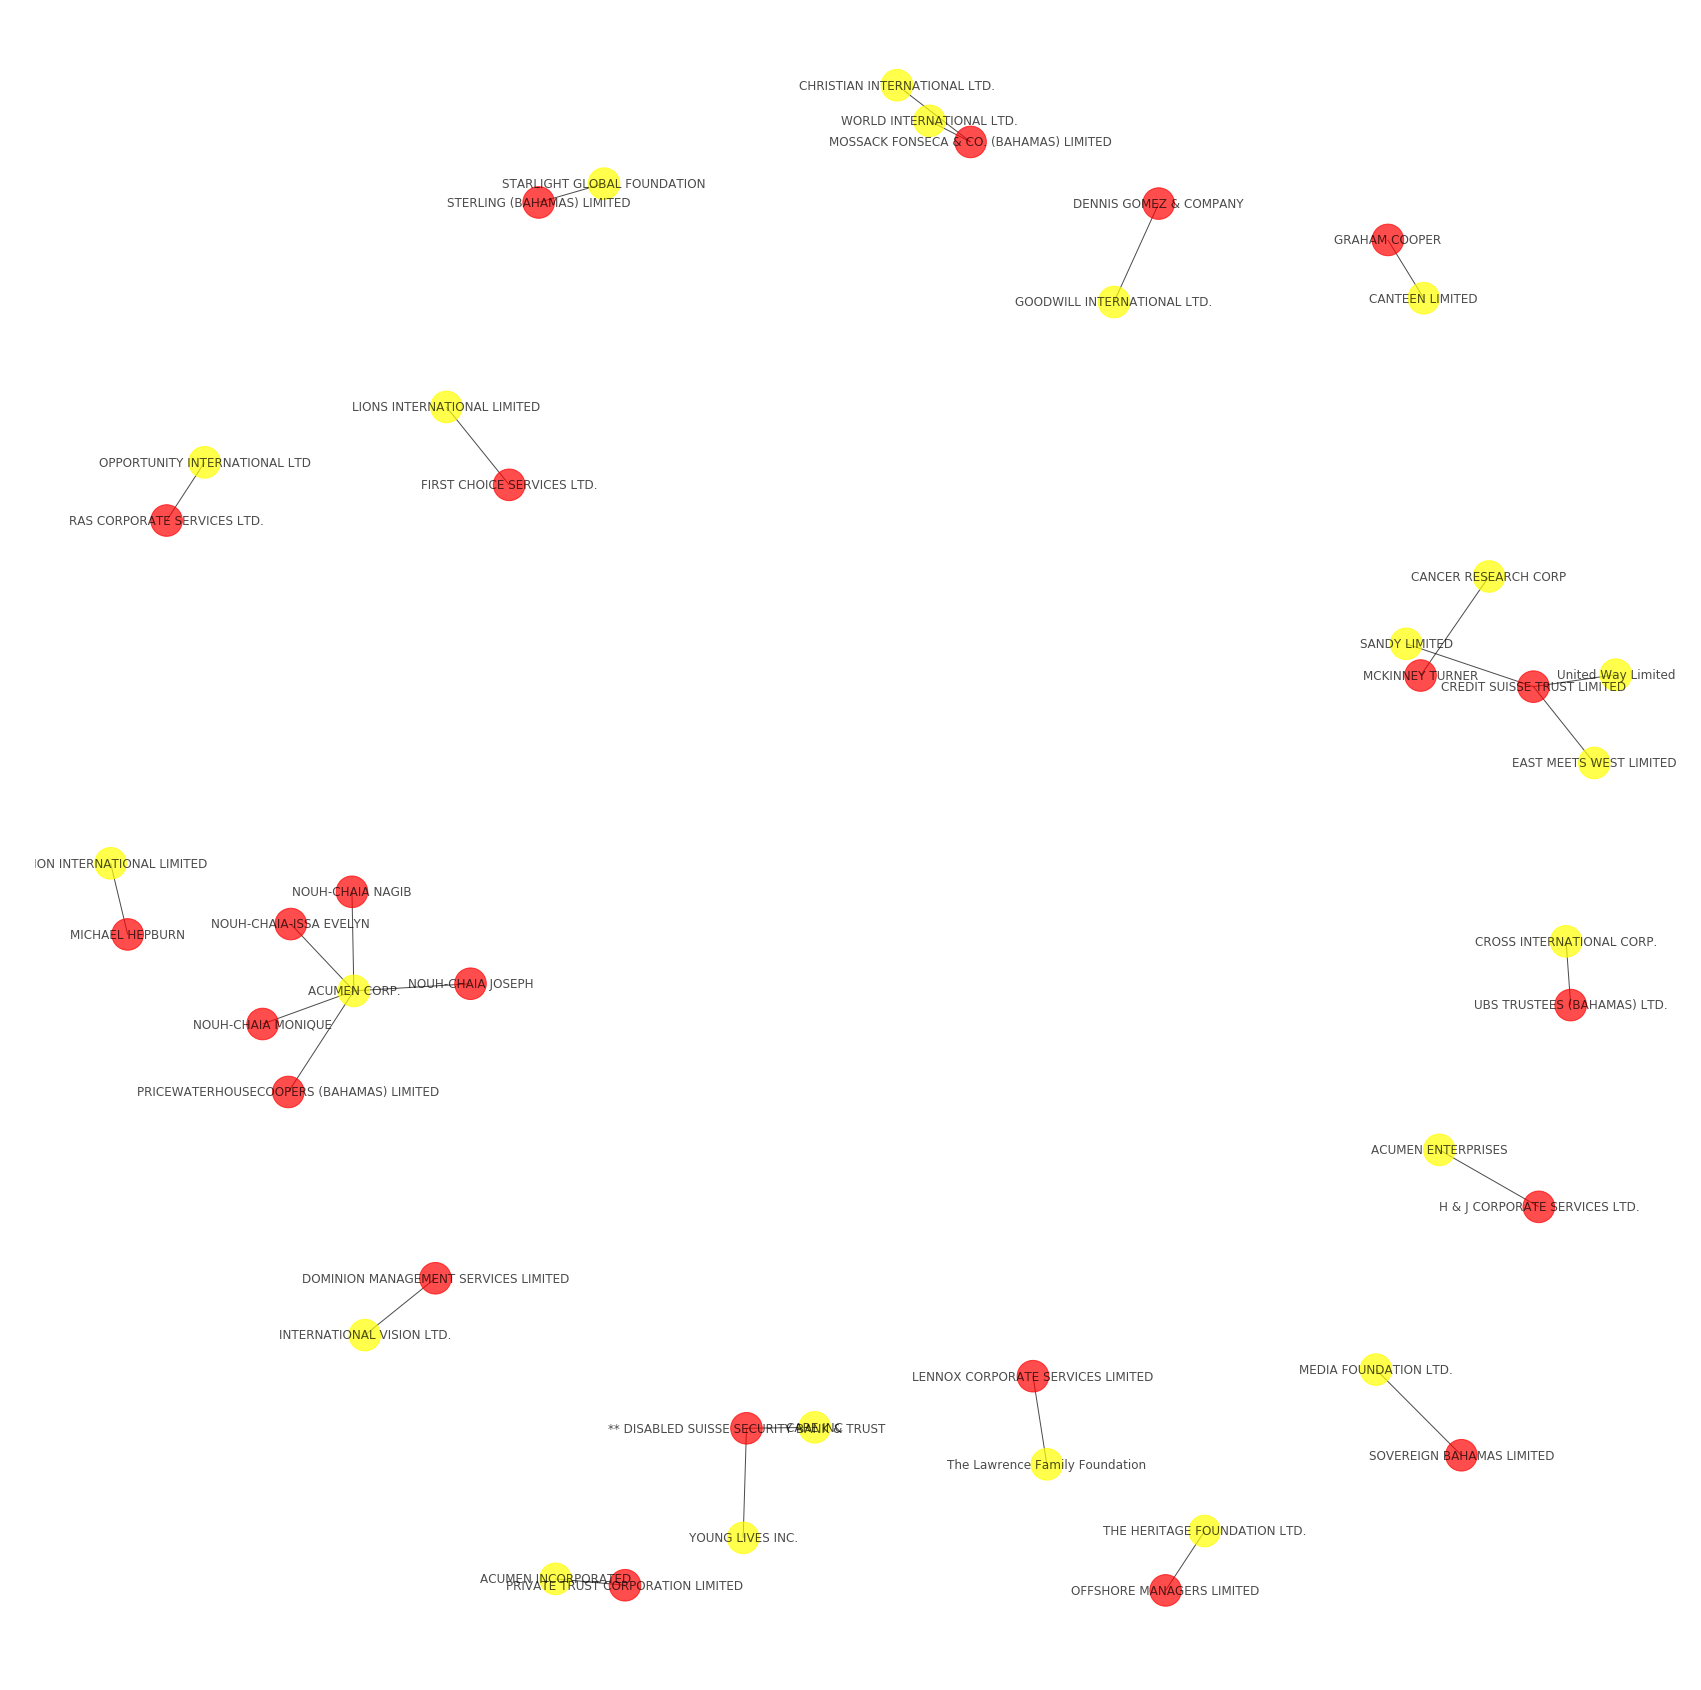

In [15]:
graph_leak_matches('bahamas')

Size before removing loners: 27
Size after removing loners: 0
Matches for bahamas papers: 
Name: 
Type: Graph
Number of nodes: 0
Number of edges: 0



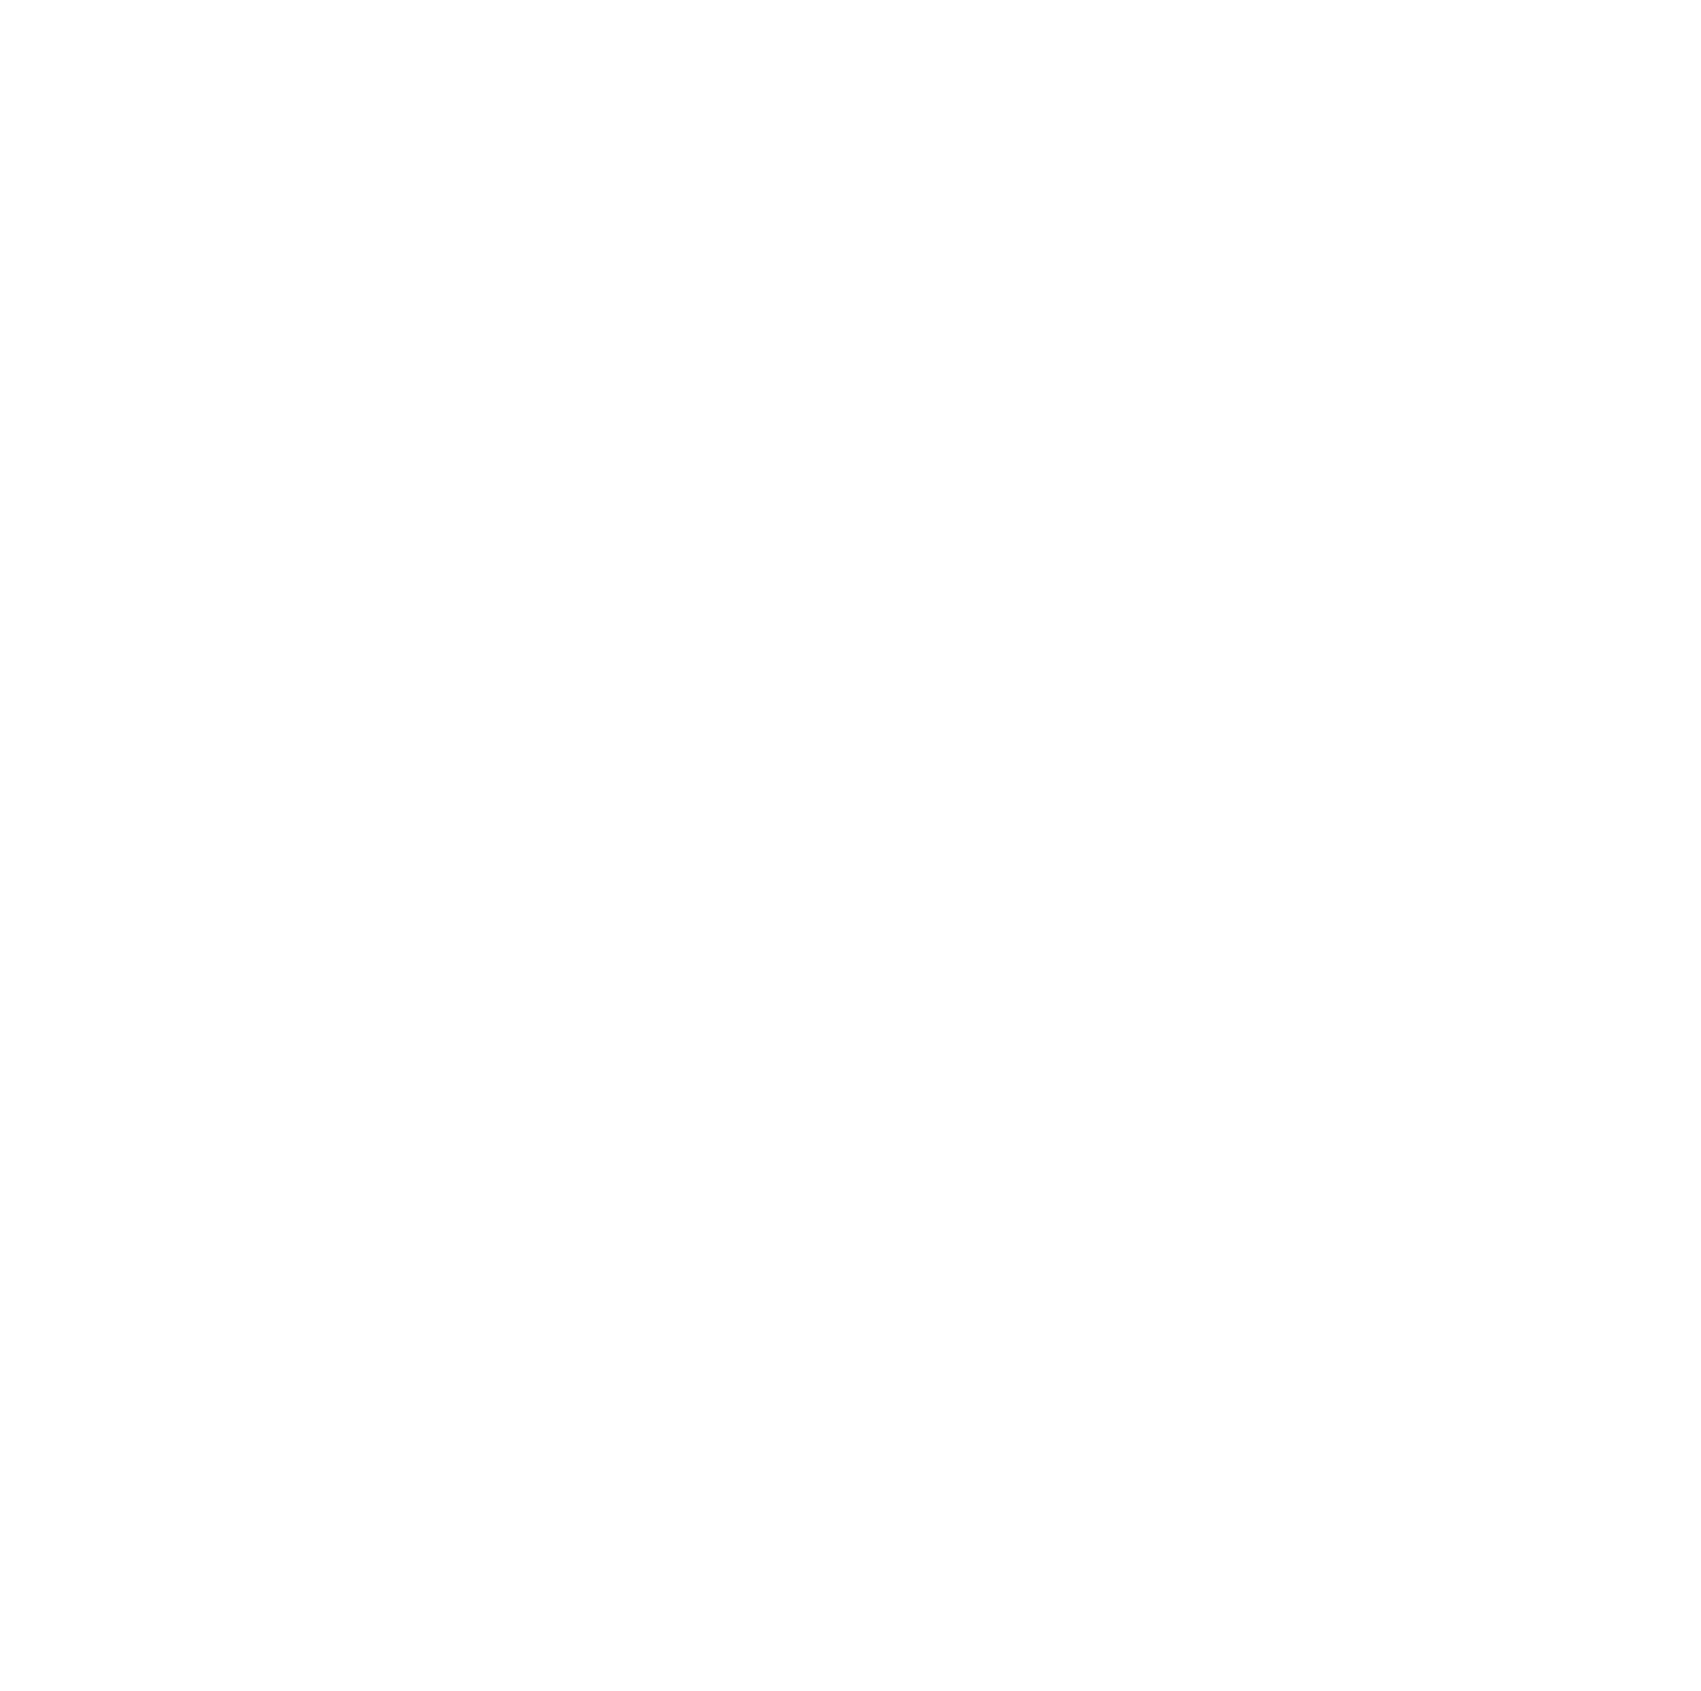

In [16]:
graph_leak_matches('bahamas', True)